## House Price

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"
import findspark
findspark.init()

## 1. Exploratory Data Analysis (EDA)

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('HousePrice').getOrCreate()

In [4]:
from google.colab import files
files.upload()

Saving housprice.csv to housprice.csv


{'housprice.csv': b'Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice\n1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,

In [5]:
df = spark.read.csv('housprice.csv', inferSchema=True, header=True)
df.show(truncate=False)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
|Id |MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [6]:
## print schema
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

In [7]:
## summary statistics
df.summary().show()

+-------+-----------------+------------------+--------+-----------------+------------------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+------------------+------------------+------------------+------------------+---------+--------+-----------+-----------+----------+------------------+---------+---------+----------+--------+--------+------------+------------+-----------------+------------+-----------------+-----------------+------------------+-------+---------+----------+----------+-----------------+------------------+-----------------+-----------------+-------------------+--------------------+------------------+-------------------+------------------+-------------------+-----------+------------------+----------+------------------+-----------+----------+------------------+------------+------------------+-----------------+----------+----------+----------+------------------+-----------------+------------------+-----

In [8]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col


In [9]:
from pyspark.sql.functions import count, when, col
df.select(
    [
        count(when(col(column_name).isNull(), column_name)).alias(column_name)
        for column_name in df.columns
    ]
).show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [10]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
import matplotlib.style as style
style.use('fivethirtyeight')

In [11]:
## Get target
a = 'SalePrice'

## Get quantitative features and delete the unnecessary features
quantitative = [f[0] for f in df.dtypes if f[1] != 'string']
quantitative.remove('SalePrice')
quantitative.remove('Id')

# Get categorical features
b = [f[0] for f in df.dtypes if f[1] == 'string']


In [12]:
b

['MSZoning',
 'LotFrontage',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

## SalePrice Histogram

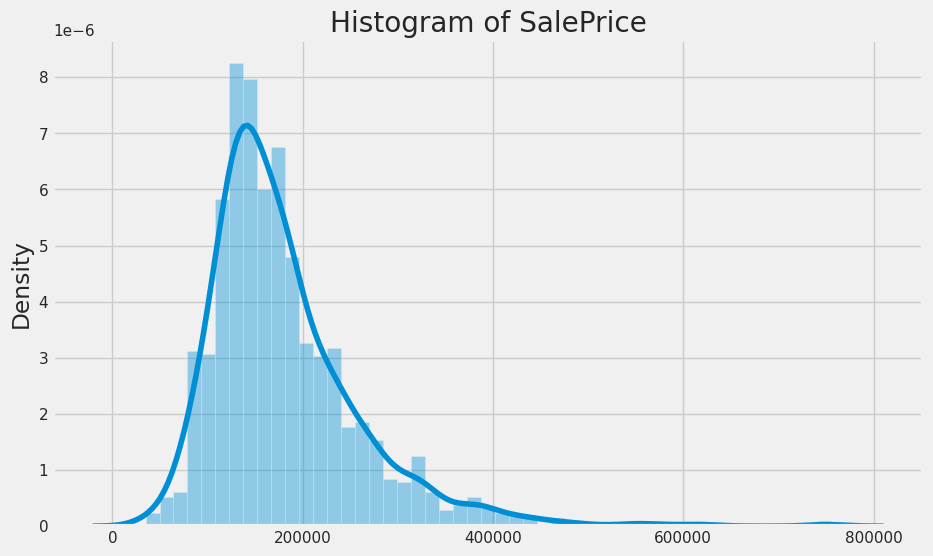

In [13]:
## Plot the Target(SalePrice)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.distplot(df.select(a).rdd.flatMap(lambda x: x).collect())
plt.title('Histogram of %s' % a)
plt.show()


## Histograms of Quantitative Features



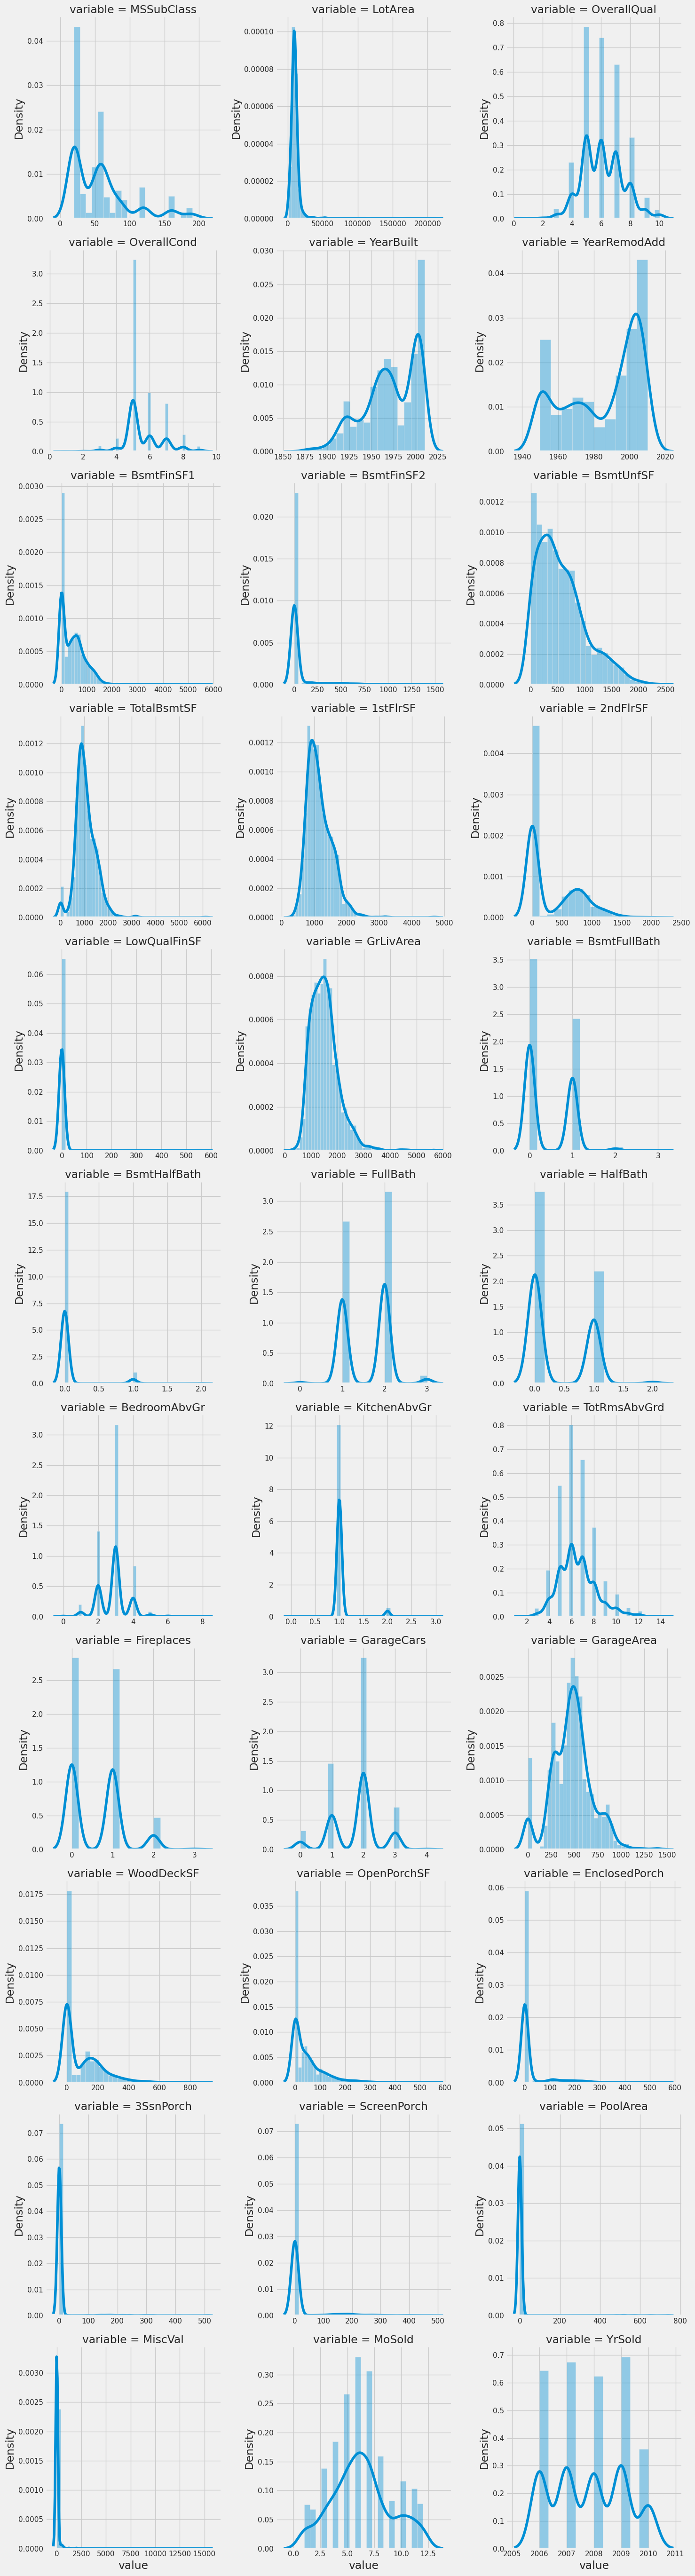

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Convert pyspark df to pandas df
df1 = df.toPandas()

## Use the melt function on the Pandas DataFrame
f = pd.melt(df1, value_vars=quantitative)

## Create a FacetGrid
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(sns.distplot, "value")

## Plot
plt.show()


## Scatterplot

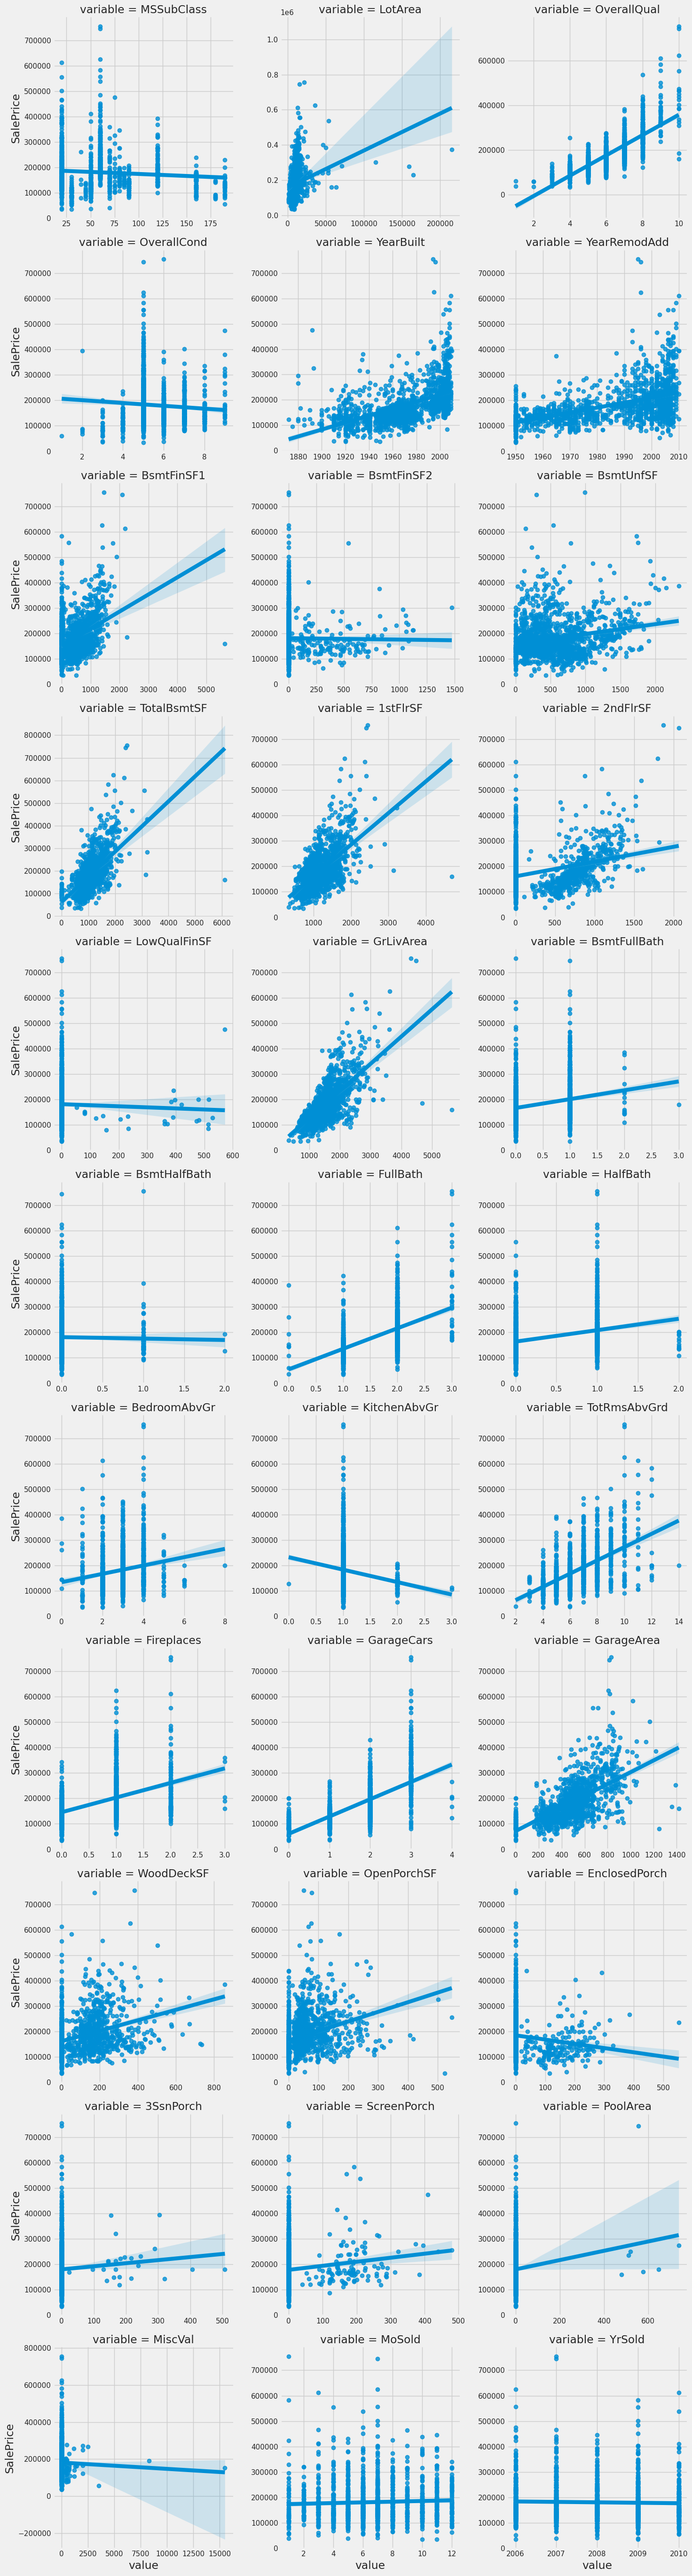

In [15]:
f = pd.melt(df1, id_vars=[a], value_vars=quantitative)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(sns.regplot, "value", a)

## plot
plt.show()


## Count plot

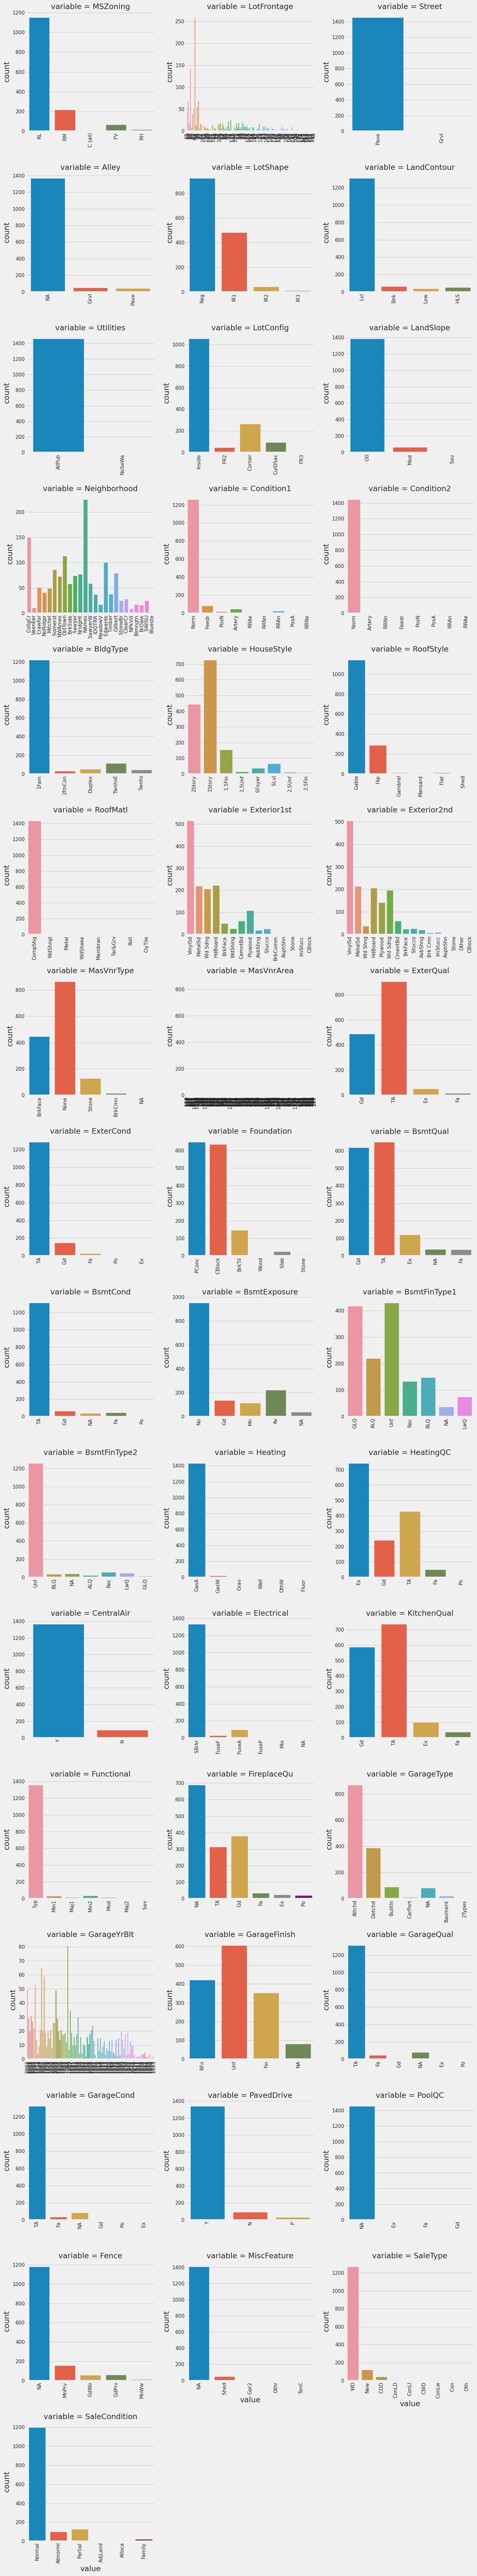

In [18]:
def countplot(x, **kwargs):
    sns.countplot(x=x)
    x = plt.xticks(rotation=90)

f = pd.melt(df1, value_vars=b)
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(countplot, 'value')

# Show the plot
plt.show()


## Box plot

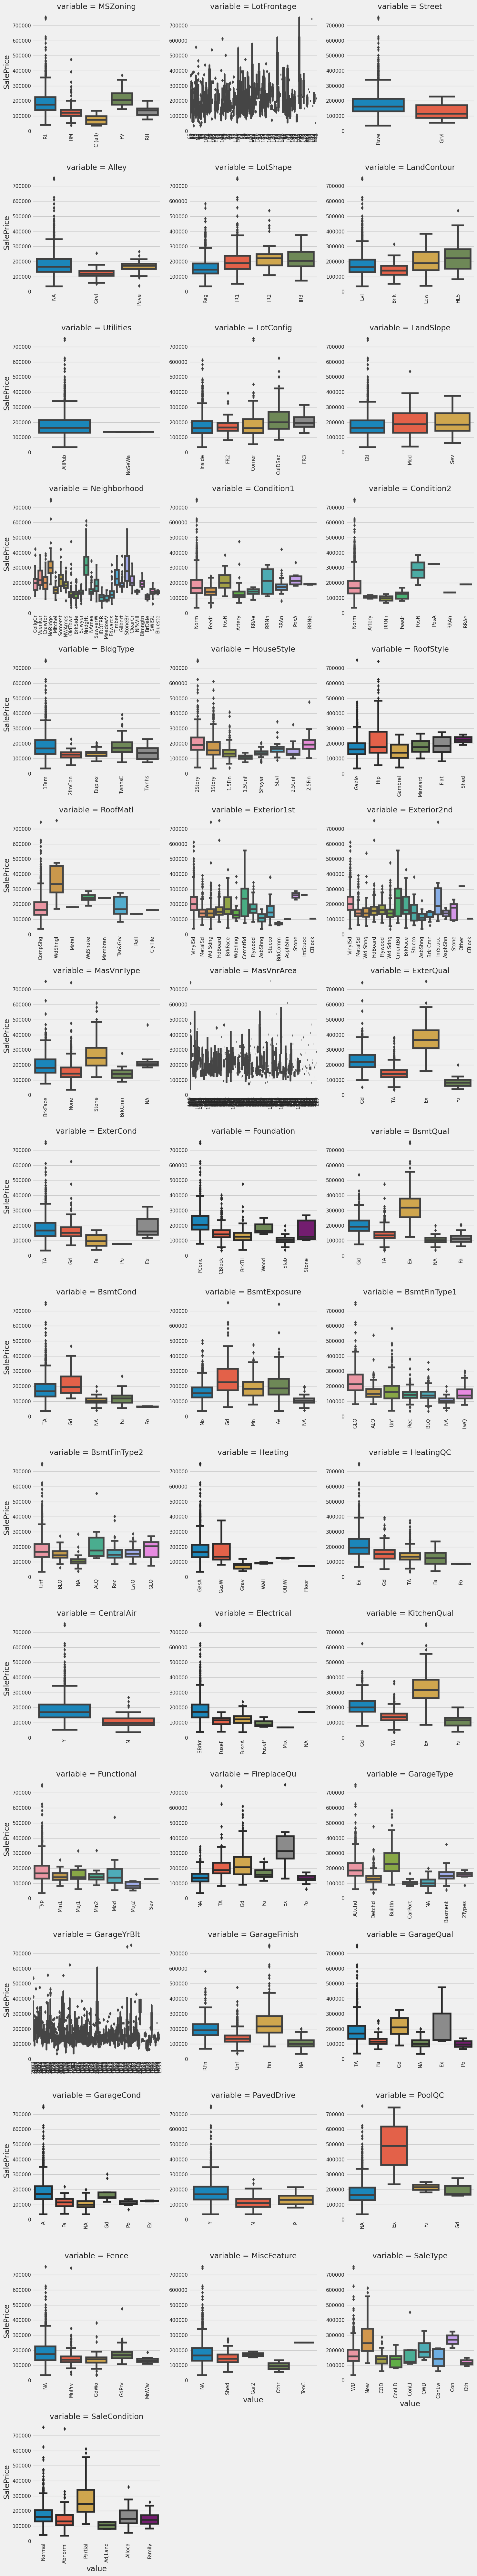

In [17]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    plt.xticks(rotation=90)
f = pd.melt(df1, id_vars=[a], value_vars=b)
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(boxplot, 'value', a)

## plot
plt.show()


## Correlation Matrix (heat map)

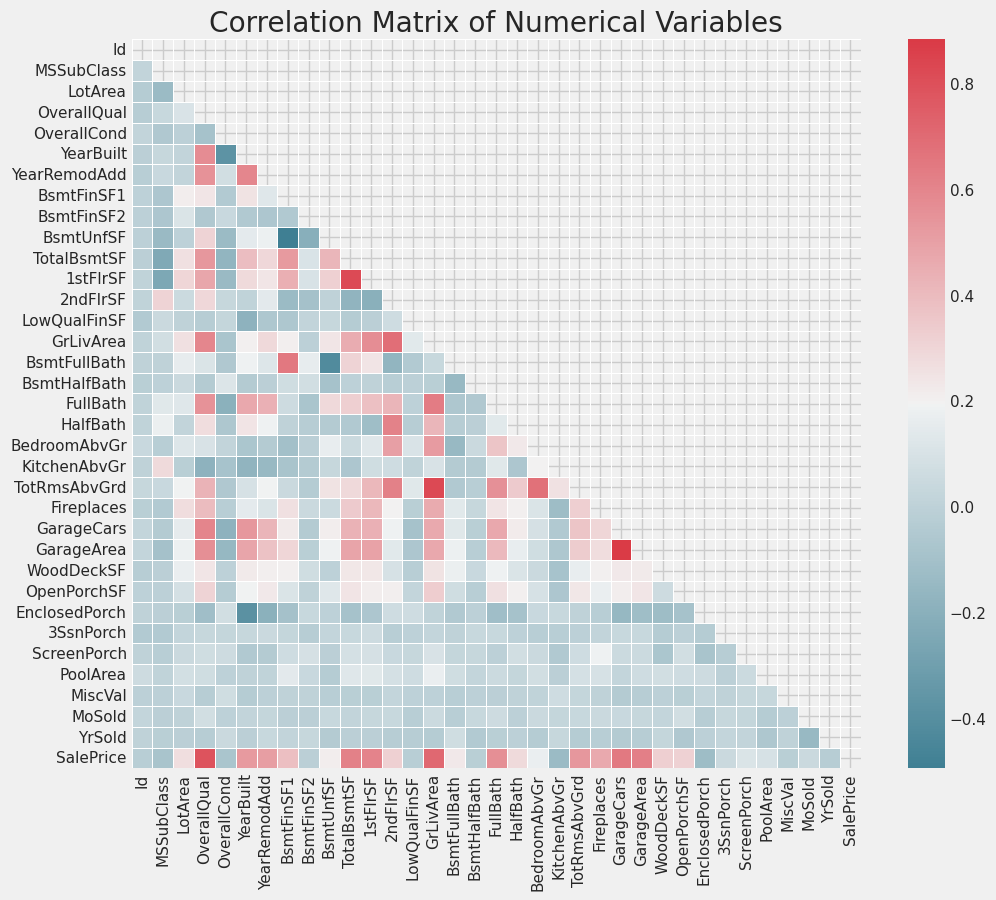

In [19]:

corr = df1.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

## matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

## custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

## heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,
            square=True, linewidths=.5, annot=False, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

## StringIndexing

In [20]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index") for col in b]


In [21]:

## create a Pipeline
pipeline = Pipeline(stages=indexers)

## using the Pipeline to transform df
indexed_df = pipeline.fit(df).transform(df)


indexed_df.show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+--------------+-----------------+------------+-----------+--------------+-----------------+---------------+---------------+---------------+----

## One-Hot Encoding

In [27]:
columns_to_drop = [f"{col}_index" for col in b]
indexed_df = indexed_df.drop(*columns_to_drop)

encoders = [OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_encoded") for col in b]
encoded_df = pipeline.fit(indexed_df).transform(indexed_df)


In [28]:
encoded_df.show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+--------------+-----------------+------------+-----------+--------------+-----------------+---------------+---------------+---------------+----

## VectorEnsembler

In [29]:
from pyspark.ml.feature import VectorAssembler

input_cols = [f"{col}_encoded" for col in b]
assembler = VectorAssembler(inputCols=input_cols, outputCol="features")

## create a Pipeline with all stages
pipeline = Pipeline(stages=indexers + encoders + [assembler])

## using the Pipeline to transform df
transformed_df = pipeline.fit(df).transform(df)


transformed_df.select("features").show(truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                                                                              |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## ML models

In [30]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [31]:
rf = RandomForestRegressor(featuresCol='features', labelCol='SalePrice')
## create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, rf])

## split the data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

## train the model
model = pipeline.fit(train_data)

## make predictions
predictions = model.transform(test_data)

# evaluate the model
evaluator = RegressionEvaluator(labelCol='SalePrice', predictionCol='prediction', metricName='rmse')